# Multiple Class Novelty Detection Under Data Distribution Shift

## Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
import time
import os

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
# To (temporarily?) solve the OMP issue
# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
try:
    from google.colab import drive
    if (not os.path.exists('/content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code')):
        drive.mount('/content/drive')
    filepath = '/content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code'
    IN_COLAB = True
except:
    IN_COLAB = False
    filepath = ''
    
runpath = os.path.join(filepath, time.strftime("run_%Y_%m_%d-%H_%M"))
if not os.path.exists(runpath):
    os.makedirs(runpath)

In [ ]:
IN_COLAB

True

## Data

### Data Loading

Obtain the datasets in the original paper from multiple sources.

In [ ]:
# MNIST Dataset
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = keras.datasets.mnist.load_data()

mnist_X_train.shape, mnist_y_train.shape, mnist_X_test.shape, mnist_y_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
# mnist_X_train.dtype
mnist_X_train = mnist_X_train.astype('float32')
mnist_X_test = mnist_X_test.astype('float32')
mnist_X_train.dtype

dtype('float32')

In [ ]:
# USPS Dataset
with h5py.File(os.path.join(filepath,'usps.h5'), 'r') as hf:
    train = hf.get('train')
    usps_X_train = np.reshape(train.get('data')[:], (-1,16,16))
    usps_y_train = train.get('target')[:]
    test = hf.get('test')
    usps_X_test = np.reshape(test.get('data')[:], (-1,16,16))
    usps_y_test = test.get('target')[:]

usps_X_train.shape, usps_y_train.shape, usps_X_test.shape, usps_y_test.shape

((7291, 16, 16), (7291,), (2007, 16, 16), (2007,))

In [ ]:
# usps_X_train.dtype
usps_X_train = usps_X_train.astype('float32')
usps_X_test = usps_X_test.astype('float32')
usps_X_train.dtype

dtype('float32')

In [ ]:
# SVHN Dataset
f = sio.loadmat(os.path.join(filepath,'train_32x32.mat'))
svhn_X_train = np.moveaxis(np.array(f['X']), -1, 0)
svhn_y_train = np.array(f['y']).squeeze()
f = sio.loadmat(os.path.join(filepath,'test_32x32.mat'))
svhn_X_test = np.moveaxis(np.array(f['X']), -1, 0)
svhn_y_test = np.array(f['y']).squeeze()

svhn_X_train.shape, svhn_y_train.shape, svhn_X_test.shape, svhn_y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

In [ ]:
# svhn_X_train.dtype
svhn_X_train = svhn_X_train.astype('float32')
svhn_X_test = svhn_X_test.astype('float32')
svhn_X_train.dtype

dtype('float32')

In [ ]:
svhn_y_train[svhn_y_train==10]=0
svhn_y_test[svhn_y_test==10]=0

### Visualize the Samples

In [ ]:
def plot_digits(X, y=None, grid=None, ax=None):
    if (X.ndim==2):
        if (ax is None):
            fig, ax = plt.subplots()
        ax.imshow(X, cmap='gray')
        ax.axis('off')
        if (y is not None):
            ax.set_title('Label ' + str(y))
        plt.show()
    else:
        if (ax is None):
            if (grid is None):
                fig, ax = plt.subplots(X.shape[0])
            else:
                fig, ax = plt.subplots(grid[0], grid[1])
        for i in range(X.shape[0]):
            ax.flatten()[i].imshow(X[i], cmap='gray')
            ax.flatten()[i].axis('off')
            if (y is not None):
                ax.flatten()[i].set_title('Label ' + str(y[i]))
        plt.show()
        
def plot_color_digits(X, y=None, grid=None, ax=None):
    if (X.ndim==3):
        if (ax is None):
            fig, ax = plt.subplots()
        ax.imshow(X)
        ax.axis('off')
        if (y is not None):
            ax.set_title('Label ' + str(y))
        plt.show()
    else:
        if (ax is None):
            if (grid is None):
                fig, ax = plt.subplots(X.shape[0])
            else:
                fig, ax = plt.subplots(grid[0], grid[1])
        for i in range(X.shape[0]):
            ax.flatten()[i].imshow(X[i])
            ax.flatten()[i].axis('off')
            if (y is not None):
                ax.flatten()[i].set_title('Label ' + str(y[i]))
        plt.show()

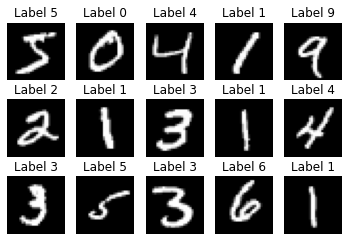

In [ ]:
plot_digits(mnist_X_train[:15],mnist_y_train[:15],(3,5))

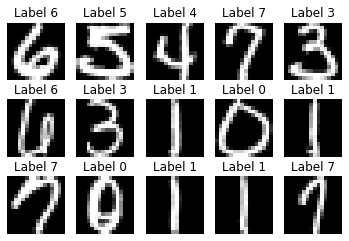

In [ ]:
plot_digits(usps_X_train[:15],usps_y_train[:15],(3,5))

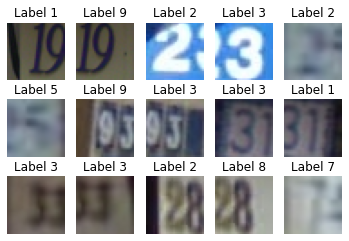

In [ ]:
plot_color_digits(svhn_X_train[:15] / 255.0,svhn_y_train[:15],(3,5))

### Data Preprocessing

Split the known categories and novel categories

In [ ]:
mnist_0_4 = np.nonzero(mnist_y_train < 5)[0]
mnist_5_9 = np.nonzero(mnist_y_train >= 5)[0]
usps_0_4 = np.nonzero(usps_y_train < 5)[0]
usps_5_9 = np.nonzero(usps_y_train >= 5)[0]
svhn_0_4 = np.nonzero(svhn_y_train < 5)[0]
svhn_5_9 = np.nonzero(svhn_y_train >= 5)[0]

In [ ]:
mnist_0_4, mnist_5_9

(array([    1,     2,     3, ..., 59991, 59994, 59996]),
 array([    0,     4,    11, ..., 59997, 59998, 59999]))

In [ ]:
usps_0_4, usps_5_9

(array([   2,    4,    6, ..., 7288, 7289, 7290]),
 array([   0,    1,    3, ..., 7269, 7271, 7275]))

In [ ]:
svhn_0_4, svhn_5_9

(array([    0,     2,     3, ..., 73252, 73253, 73254]),
 array([    1,     5,     6, ..., 73251, 73255, 73256]))

In [ ]:
mnist_0_4t = np.nonzero(mnist_y_test < 5)[0]
mnist_5_9t = np.nonzero(mnist_y_test >= 5)[0]
usps_0_4t = np.nonzero(usps_y_test < 5)[0]
usps_5_9t = np.nonzero(usps_y_test >= 5)[0]
svhn_0_4t = np.nonzero(svhn_y_test < 5)[0]
svhn_5_9t = np.nonzero(svhn_y_test >= 5)[0]

Image Resize

In [ ]:
mnist_X_train = mnist_X_train[:, :, :, np.newaxis]
mnist_X_train = tf.broadcast_to(mnist_X_train, mnist_X_train.shape[:-1] + (3,))
mnist_X_train = tf.image.resize(mnist_X_train, (32,32))

In [ ]:
mnist_X_train.shape

TensorShape([60000, 32, 32, 3])

In [ ]:
usps_X_train = usps_X_train[:, :, :, np.newaxis]
usps_X_train = tf.broadcast_to(usps_X_train, usps_X_train.shape[:-1] + (3,))
usps_X_train = tf.image.resize(usps_X_train, (32,32))

In [ ]:
usps_X_train.shape

TensorShape([7291, 32, 32, 3])

In [ ]:
svhn_X_train = tf.cast(tf.convert_to_tensor(svhn_X_train),'float32')
svhn_X_train.shape

TensorShape([73257, 32, 32, 3])

In [ ]:
mnist_X_test = mnist_X_test[:, :, :, np.newaxis]
mnist_X_test = tf.broadcast_to(mnist_X_test, mnist_X_test.shape[:-1] + (3,))
mnist_X_test = tf.image.resize(mnist_X_test, (32,32))

In [ ]:
mnist_X_test.shape

TensorShape([10000, 32, 32, 3])

In [ ]:
usps_X_test = usps_X_test[:, :, :, np.newaxis]
usps_X_test = tf.broadcast_to(usps_X_test, usps_X_test.shape[:-1] + (3,))
usps_X_test = tf.image.resize(usps_X_test, (32,32))

In [ ]:
usps_X_test.shape

TensorShape([2007, 32, 32, 3])

In [ ]:
svhn_X_test = tf.cast(tf.convert_to_tensor(svhn_X_test),'float32')
svhn_X_test.shape

TensorShape([26032, 32, 32, 3])

Data Scaling

In [ ]:
tf.math.reduce_min(mnist_X_train), tf.math.reduce_max(mnist_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [ ]:
tf.math.reduce_min(usps_X_train), tf.math.reduce_max(usps_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
tf.math.reduce_min(svhn_X_train), tf.math.reduce_max(svhn_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [ ]:
mnist_X_train = mnist_X_train / 255.0
svhn_X_train = svhn_X_train / 255.0

In [ ]:
tf.math.reduce_min(mnist_X_train), tf.math.reduce_max(mnist_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
tf.math.reduce_min(svhn_X_train), tf.math.reduce_max(svhn_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

Data Normalization (disabled)

In [ ]:
mnist_train_mean = np.mean(mnist_X_train,)
mnist_train_std  = np.std(mnist_X_train)
# mnist_X_train    = (mnist_X_train - mnist_train_mean) / mnist_train_std
# mnist_X_test     = (mnist_X_test - mnist_train_mean) / mnist_train_std

In [ ]:
mnist_train_mean, mnist_train_std

(0.13085152, 0.28923184)

In [ ]:
usps_train_mean = np.mean(usps_X_train)
usps_train_std  = np.std(usps_X_train)
# usps_X_train    = (usps_X_train - usps_train_mean) / usps_train_std
# usps_X_test     = (usps_X_test - usps_train_mean) / usps_train_std

In [ ]:
usps_train_mean, usps_train_std

(0.2544808, 0.3481659)

In [ ]:
svhn_train_mean = np.mean(svhn_X_train)
svhn_train_std  = np.std(svhn_X_train)
# svhn_X_train    = (svhn_X_train - svhn_train_mean) / svhn_train_std
# svhn_X_test     = (svhn_X_test - svhn_train_mean) / svhn_train_std

In [ ]:
svhn_train_mean, svhn_train_std

(0.45141736, 0.1992912)

In [ ]:
# mnist_train_mean = 0.0
# mnist_train_std  = 1.0
# usps_train_mean = 0.0
# usps_train_std  = 1.0
# svhn_train_mean = 0.0
# svhn_train_std  = 1.0

## Model Components

### Feature Encoder Network

In [ ]:
def FeatureEncoder(name=None):
    '''
    Return a Feature Encoder.
    '''
    fe_input = keras.Input(shape=(32,32,3))
    x = keras.layers.Dropout(0.2)(fe_input)
    x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    x = keras.layers.MaxPooling2D(2, strides=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    x = keras.layers.MaxPooling2D(2, strides=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    fe_out = keras.layers.Flatten()(x)
    if (name is None):
        fe = keras.Model(inputs=fe_input, outputs=fe_out, name='FeatureExtractor')
    else:
        fe = keras.Model(inputs=fe_input, outputs=fe_out, name=name)
    return fe

In [ ]:
fe_demo = FeatureEncoder()
fe_demo.summary()

Model: "FeatureExtractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)     

### Classification Network

In [ ]:
def ClassificationNet(name=None):
    '''
    Return a Classification Network.
    Input: None.
    Output: A tuple containing the handle of input layer and output layer.
    '''
    cl_input = keras.Input(shape=[128])
    x = keras.layers.Dense(128, activation='relu')(cl_input)
    cl_out = keras.layers.Dense(5, activation='relu')(x)
    if (name is None):
        cl = keras.Model(inputs=cl_input, outputs=cl_out, name='ClassificationNetwork')
    else:
        cl = keras.Model(inputs=cl_input, outputs=cl_out, name=name)
    return cl

In [ ]:
cl_demo = ClassificationNet()
cl_demo.summary()

Model: "ClassificationNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 17,157
Trainable params: 17,157
Non-trainable params: 0
_________________________________________________________________


## Build the Model

### Baseline: Softmax

In [ ]:
def SoftMaxModel():
    # Input layer
    sm_input_src = keras.Input(shape=(32,32,3), name="SourceInput")

    # Fed to the feature extractor
    sm_fe = FeatureEncoder()
    sm_fe_src = sm_fe(sm_input_src)

    # Source representation flows to the classification network
    sm_out_cl = ClassificationNet()(sm_fe_src)

    # Final model
    model = keras.Model(
        inputs=[sm_input_src],
        outputs=[sm_out_cl]
    )

    return (model)

In [ ]:
mod_softmax = SoftMaxModel()
mod_softmax.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SourceInput (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
FeatureExtractor (Functional (None, 128)               312256    
_________________________________________________________________
ClassificationNetwork (Funct (None, 5)                 17157     
Total params: 329,413
Trainable params: 329,413
Non-trainable params: 0
_________________________________________________________________


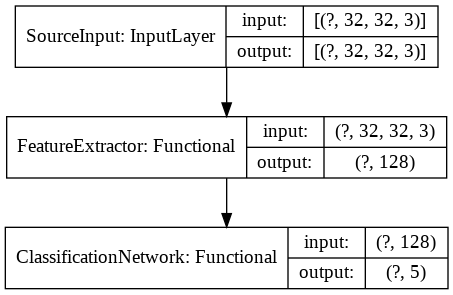

In [ ]:
keras.utils.plot_model(mod_softmax, os.path.join(runpath,'softmax_model.png'), show_shapes=True)

### Helper Functions

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return tf.gather(X, idx), tf.gather(y, idx)

In [ ]:
def print_status_bar(iteration, total, loss):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in loss])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

### Training Loop

In [ ]:
# def train_softmax_model(model, X_src, y_src, batch_size=64, n_epochs=50):
#     history = model.fit(X_src, y_src, batch_size, n_epochs, validation_data = (X_src, y_src))
#     _, accuracy = model.evaluate(X_src, y_src)
#     print('Accuracy: %.2f' % (accuracy*100))
#     return history

In [ ]:
def train_softmax_model(model, X_src, y_src, optimizers, 
                        n_epochs=50,start_epoch=1,
                        batch_size=64, name=None):
    
    # Get the sample size, number of steps, source size, and target size
    n_samples = len(X_src)
    n_steps = n_samples // batch_size
    src_size = batch_size

    # Define loss functions
    layers = model.layers
    cat_loss = keras.losses.CategoricalCrossentropy()
    
    # Define loss metrics and the history tracker
    loss_name = ['loss_ce']
    mean_loss = []
    for l in loss_name:
        mean_loss.append(keras.metrics.Mean(name=l))
    history = []
    
    for epoch in range(1, n_epochs + 1):
        print("Epoch {}/{}".format(epoch, n_epochs))
        
        for step in range(1, n_steps + 1):
            # Sample a batch from source and target data
            X_src_batch, y_src_batch = random_batch(X_src, y_src, src_size)
            
            with tf.GradientTape(persistent=True) as tape:
                # Feed-forward Network
                output = model((X_src_batch), training=True)

                # Calculate the losses
                loss_ce = cat_loss(tf.one_hot(y_src_batch,5),
                                   keras.activations.softmax(output))
                
            # Apply the gradients
            gradient_fe = tape.gradient(loss_ce,
                model.get_layer('FeatureExtractor').trainable_variables)
            optimizers[0].apply_gradients(zip(gradient_fe,
                model.get_layer('FeatureExtractor').trainable_variables))
            gradient_ce = tape.gradient(loss_ce,
                model.get_layer('ClassificationNetwork').trainable_variables)
            optimizers[1].apply_gradients(zip(gradient_ce,
                model.get_layer('ClassificationNetwork').trainable_variables))
            
            mean_loss[0](loss_ce)

            # Print Status Bar
            print_status_bar(step * batch_size, n_samples, mean_loss)

            # Save the history
            history.append([m.result() for m in mean_loss])
            
            # Delete the tape
            del(tape)

        # Refresh the status bar
        print_status_bar(n_samples, n_samples, mean_loss)
        
        # Save the model at this epoch
        model.save(os.path.join(runpath,'SOFTMAX_'+ name + '_epoch_' + str(epoch) + time.strftime("_%Y_%m_%d-%H_%M_%S")))
        
        # Reset the metrics
        for loss in mean_loss:
            loss.reset_states()

    return np.array(history)

### Novelty Detector

In [ ]:
def novelty_detector(model, X, c_softmax=1.0, c_gloss=1.0, c_dscore=1.0):
    '''
    A novelty detector based on softmax. From the paper, the maximum softmax
    probability alone can be used as the novelty score for the Softmax model
    '''
    batch_size = 64
    n_batch = len(X) // batch_size
    softmax_score = np.array([]).reshape(0)

    print('Novelty Detector - Computing Outputs')
    
    for i in range(n_batch):
        s = i * batch_size
        e = (i+1) * batch_size
        out_cl = model((X[s:e]))
        
        softmax_score = np.concatenate((softmax_score,
            tf.math.reduce_max(tf.nn.softmax(out_cl),
                               axis=1)))
    
    s = n_batch * batch_size
    e = len(X)
    out_cl = model((X[s:e]))
    
    softmax_score = np.concatenate((softmax_score,
        tf.math.reduce_max(tf.nn.softmax(out_cl),
                           axis=1)))
    
    return (softmax_score)

In [ ]:
def plot_auc_curve(fpr, tpr, ax):
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange',
             lw=2.0, label='ROC curve (area = %0.3f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='gray', lw=1.0, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

## Evaluation

### MNIST to USPS

#### Training

In [ ]:
# mod_softmax.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# mod_softmax.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# X_src = tf.gather(mnist_X_train, mnist_0_4)
# y_src = tf.gather(mnist_y_train, mnist_0_4)

# history = train_softmax_model(mod_softmax,X_src,y_src,batch_size=64, n_epochs=5)

In [ ]:
mod_softmax = SoftMaxModel()

In [ ]:
opt = []
for i in range(2):
    opt.append(keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
X_src = tf.gather(mnist_X_train, mnist_0_4)
y_src = tf.gather(mnist_y_train, mnist_0_4)

In [ ]:
history = train_softmax_model(mod_softmax, X_src, y_src,
                              optimizers = opt, n_epochs=10,
                              batch_size=64, name='mnist_usps')

Epoch 1/10
30596/30596 - loss_ce: 0.4928
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_mnist_usps_epoch_1_2020_12_05-21_29_54/assets
Epoch 2/10
30596/30596 - loss_ce: 0.3653
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_mnist_usps_epoch_2_2020_12_05-21_30_04/assets
Epoch 3/10
30596/30596 - loss_ce: 0.3504
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_mnist_usps_epoch_3_2020_12_05-21_30_13/assets
Epoch 4/10
30596/30596 - loss_ce: 0.2573
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/r

In [ ]:
history.shape

(4780, 1)

Visualize the Training History

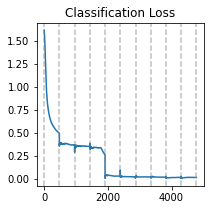

In [ ]:
epoch_index = np.linspace(0,len(history),11)
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(range(len(history)), history[:,0])
ax.set_title('Classification Loss')
for j in range(len(epoch_index)):
    ax.axvline(epoch_index[j], c='gray', ls='--', alpha=0.5)
    
fig.savefig(os.path.join(runpath, 'softmax_mnist_usps_loss.png'), dpi=300)
fig.show()

#### Diagnostic Tests

**Load model trained before**

In [ ]:
# mod_softmax = tf.keras.models.load_model('SOFTMAX_mnist_usps_epoch_5_2020_12_04-21_51_28')

Sample a random batch of samples and see the softmax probability scores.

In [ ]:
index = np.random.randint(0, min(len(usps_0_4), len(usps_5_9)), 10)
X_origin_rand = tf.gather(usps_X_train, usps_0_4[index])
y_origin_rand = usps_y_train[usps_0_4[index]]
X_novel_rand = tf.gather(usps_X_train, usps_5_9[index])
y_novel_rand = usps_y_train[usps_5_9[index]]

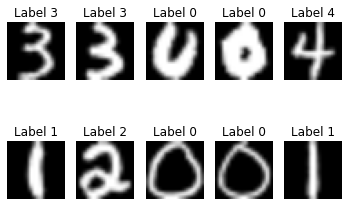

In [ ]:
plot_color_digits(X_origin_rand, y_origin_rand, (2,5))

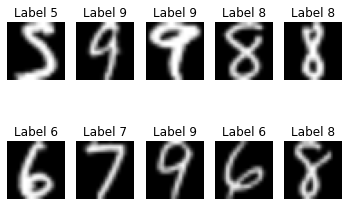

In [ ]:
plot_color_digits(X_novel_rand, y_novel_rand, (2,5))

In [ ]:
y_origin_pred = mod_softmax(X_origin_rand)
y_novel_pred = mod_softmax(X_novel_rand)

In [ ]:
tf.nn.softmax(y_origin_pred), tf.math.argmax(y_origin_pred,axis=1).numpy(), y_origin_rand

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[5.5355859e-08, 5.8596161e-08, 5.5355859e-08, 9.9999893e-01,
         9.6545784e-07],
        [3.0040763e-07, 3.0040763e-07, 3.2040256e-07, 9.9999714e-01,
         1.8499204e-06],
        [6.2506013e-02, 8.2093831e-03, 1.6780137e-04, 1.6780137e-04,
         9.2894900e-01],
        [8.6787987e-01, 9.3354695e-03, 9.3354695e-03, 9.3354695e-03,
         1.0411384e-01],
        [6.5399227e-08, 4.3301920e-08, 4.3301920e-08, 1.0190777e-07,
         9.9999976e-01],
        [8.2551492e-03, 9.7620332e-01, 6.2602374e-04, 3.9461159e-04,
         1.4520993e-02],
        [1.1810099e-04, 1.1810099e-04, 9.9952769e-01, 1.1810099e-04,
         1.1810099e-04],
        [9.4074196e-01, 5.4853051e-03, 3.3998504e-02, 5.4853051e-03,
         1.4288846e-02],
        [9.7398496e-01, 2.4287724e-03, 1.7216194e-02, 3.9413637e-03,
         2.4287724e-03],
        [3.5563578e-06, 9.9986684e-01, 2.2587053e-06, 1.9464296e-06,
         1.2540325e-04]], dtype=flo

In [ ]:
tf.nn.softmax(y_novel_pred), tf.math.argmax(y_novel_pred,axis=1).numpy(), y_novel_rand

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[1.2279177e-06, 9.1496531e-06, 1.2279177e-06, 9.9998724e-01,
         1.2279177e-06],
        [6.5213585e-06, 3.2052005e-06, 8.4851075e-07, 8.4851075e-07,
         9.9998856e-01],
        [7.0902696e-03, 4.5357931e-01, 2.4070421e-02, 3.1038234e-01,
         2.0487764e-01],
        [1.6915386e-03, 7.3510413e-03, 3.4948226e-02, 4.2682576e-01,
         5.2918339e-01],
        [5.3450814e-03, 8.0566514e-01, 1.3795969e-01, 1.7664419e-02,
         3.3365685e-02],
        [7.3010065e-03, 5.8219128e-04, 1.2316883e-03, 3.9160784e-04,
         9.9049348e-01],
        [8.4738387e-03, 5.8163083e-01, 3.2411915e-01, 8.4738387e-03,
         7.7302434e-02],
        [1.9043081e-06, 8.7698521e-05, 1.9043081e-06, 3.2524899e-06,
         9.9990523e-01],
        [9.0291834e-01, 2.0694660e-03, 3.2088670e-03, 2.0694660e-03,
         8.9733817e-02],
        [4.3602451e-03, 8.5290506e-02, 1.2220210e-02, 1.1334246e-01,
         7.8478658e-01]], dtype=flo

In [ ]:
tf.math.reduce_max(y_origin_pred,axis=1).numpy(), tf.math.reduce_max(y_novel_pred,axis=1).numpy()

(array([16.709482 , 15.018123 ,  8.619028 ,  4.5322323, 16.955069 ,
         7.8135242,  9.043498 ,  5.144596 ,  5.99401  , 13.149381 ],
       dtype=float32),
 array([13.610178 , 13.979772 ,  4.158447 ,  5.7456965,  5.0154915,
         7.8356977,  4.2288523, 13.171297 ,  6.0783415,  5.1928835],
       dtype=float32))

#### Novelty Detector on Target Training Set

In [ ]:
X_origin = tf.gather(usps_X_train, usps_0_4)
X_novel = tf.gather(usps_X_train, usps_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_softmax, X_tgt)

Novelty Detector - Computing Outputs


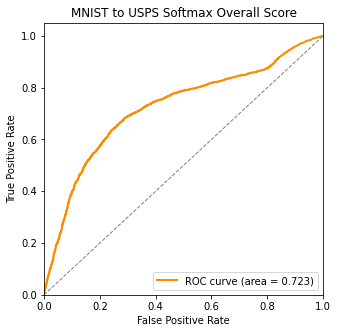

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('MNIST to USPS Softmax Overall Score')

fig.savefig(os.path.join(runpath, 'softmax_mnist_usps_eval_train.png'), dpi=300)
fig.show()

#### Novelty Detector on Target Test Set

In [ ]:
X_origin = tf.gather(usps_X_test, usps_0_4t)
X_novel = tf.gather(usps_X_test, usps_5_9t)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_softmax, X_tgt)

Novelty Detector - Computing Outputs


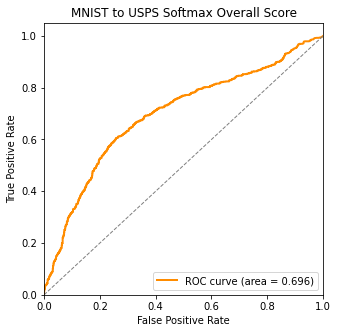

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('MNIST to USPS Softmax Overall Score')

fig.savefig(os.path.join(runpath, 'softmax_mnist_usps_eval_test.png'), dpi=300)
fig.show()

### SVHN to MNIST/USPS

#### Training

In [ ]:
mod_softmax = SoftMaxModel()

In [ ]:
opt = []
for i in range(2):
    opt.append(keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
X_src_2 = tf.gather(svhn_X_train, svhn_0_4)
y_src_2 = tf.gather(svhn_y_train, svhn_0_4)

In [ ]:
history_2 = train_softmax_model(mod_softmax, X_src_2, y_src_2,
                                optimizers=opt, n_epochs=10,
                                batch_size=64, name='svhn_mnist')

Epoch 1/10
45349/45349 - loss_ce: 1.4071
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_svhn_mnist_epoch_1_2020_12_05-21_37_43/assets
Epoch 2/10
45349/45349 - loss_ce: 0.9719
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_svhn_mnist_epoch_2_2020_12_05-21_37_56/assets
Epoch 3/10
45349/45349 - loss_ce: 0.8960
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_svhn_mnist_epoch_3_2020_12_05-21_38_10/assets
Epoch 4/10
45349/45349 - loss_ce: 0.8696
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_svhn_mnist_epoch_4_2020_12_05-21_38_22/assets
Epoch 5/10
45349/45349 - loss_ce: 0.8397
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFT

In [ ]:
history_2.shape

(7080, 1)

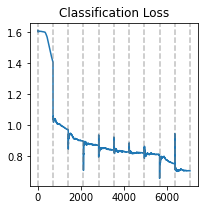

In [ ]:
epoch_index = np.linspace(0,len(history_2),11)
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(range(len(history_2)), history_2[:,0])
ax.set_title('Classification Loss')
for j in range(len(epoch_index)):
    ax.axvline(epoch_index[j], c='gray', ls='--', alpha=0.5)
    
fig.savefig(os.path.join(runpath, 'softmax_svhn_mnist_loss.png'), dpi=300)
fig.show()

#### Diagnostic Tests

**Load model trained before**

In [ ]:
# mod_softmax = tf.keras.models.load_model('SOFTMAX_mnist_usps_epoch_5_2020_12_04-21_51_28')

Sample a random batch of samples and see the softmax probability scores.

In [ ]:
index = np.random.randint(0, min(len(mnist_0_4), len(mnist_5_9)), 10)
X_origin_rand = tf.gather(mnist_X_train, mnist_0_4[index])
y_origin_rand = mnist_y_train[mnist_0_4[index]]
X_novel_rand = tf.gather(mnist_X_train, mnist_5_9[index])
y_novel_rand = mnist_y_train[mnist_5_9[index]]

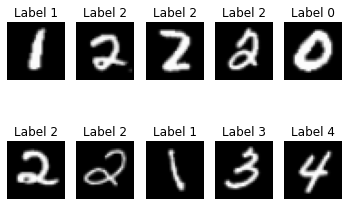

In [ ]:
plot_color_digits(X_origin_rand, y_origin_rand, (2,5))

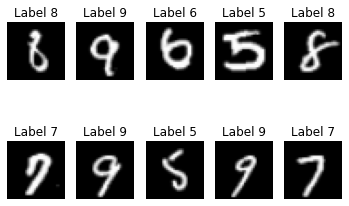

In [ ]:
plot_color_digits(X_novel_rand, y_novel_rand, (2,5))

In [ ]:
y_origin_pred = mod_softmax(X_origin_rand)
y_novel_pred = mod_softmax(X_novel_rand)

In [ ]:
tf.nn.softmax(y_origin_pred), tf.math.argmax(y_origin_pred,axis=1).numpy(), y_origin_rand

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[2.8684331e-04, 1.8420869e-01, 2.8684331e-04, 2.8684331e-04,
         8.1493074e-01],
        [9.7443657e-03, 9.7443657e-03, 9.6102250e-01, 9.7443657e-03,
         9.7443657e-03],
        [8.8460399e-11, 8.8460399e-11, 1.0000000e+00, 8.8460399e-11,
         8.8460399e-11],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [1.7287518e-01, 1.7287518e-01, 3.0849925e-01, 1.7287518e-01,
         1.7287518e-01],
        [3.8938184e-04, 3.8938184e-04, 9.9844259e-01, 3.8938184e-04,
         3.8938184e-04],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [2.2294698e-04, 9.9910814e-01, 2.2294698e-04, 2.2294698e-04,
         2.2294698e-04],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01]], dtype=flo

In [ ]:
tf.nn.softmax(y_novel_pred), tf.math.argmax(y_novel_pred,axis=1).numpy(), y_novel_rand

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[9.0615496e-02, 9.0615496e-02, 9.0615496e-02, 9.0615496e-02,
         6.3753802e-01],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [1.6868442e-01, 1.6868442e-01, 3.2526228e-01, 1.6868442e-01,
         1.6868442e-01],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [1.3613008e-03, 1.3613008e-03, 9.9455476e-01, 1.3613008e-03,
         1.3613008e-03],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [3.9084922e-04, 3.9084922e-04, 9.9843651e-01, 3.9084922e-04,
         3.9084922e-04],
        [9.5632073e-05, 9.5632073e-05, 9.9961734e-01, 9.5632073e-05,
         9.5632073e-05]], dtype=flo

In [ ]:
tf.math.reduce_max(y_origin_pred,axis=1).numpy(), tf.math.reduce_max(y_novel_pred,axis=1).numpy()

(array([ 7.9519224 ,  4.5913086 , 23.148466  ,  0.        ,  0.57914954,
         7.8493915 ,  0.        ,  8.407684  ,  0.        ,  0.        ],
       dtype=float32),
 array([1.9509887, 0.       , 0.       , 0.6566022, 0.       , 6.5938544,
        0.       , 0.       , 7.845624 , 9.25462  ], dtype=float32))

#### Novelty Detector on Target Training Set

To MNIST dataset:

In [ ]:
X_origin = tf.gather(mnist_X_train, mnist_0_4)
X_novel = tf.gather(mnist_X_train, mnist_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_softmax, X_tgt)

Novelty Detector - Computing Outputs


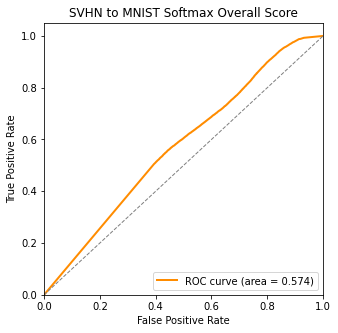

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('SVHN to MNIST Softmax Overall Score')

fig.savefig(os.path.join(runpath, 'softmax_svhn_mnist_eval_train.png'), dpi=300)
fig.show()

To USPS dataset:

In [ ]:
X_origin = tf.gather(usps_X_train, usps_0_4)
X_novel = tf.gather(usps_X_train, usps_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_softmax, X_tgt)

Novelty Detector - Computing Outputs


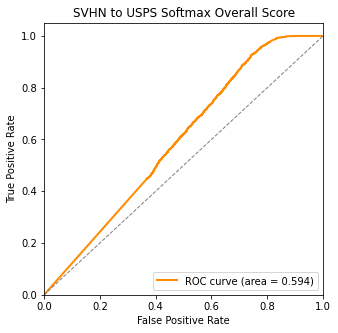

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('SVHN to USPS Softmax Overall Score')

fig.savefig(os.path.join(runpath, 'softmax_svhn_usps_eval_train.png'), dpi=300)
fig.show()

#### Novelty Detector on Target Test Set

To MNIST:

In [ ]:
X_origin = tf.gather(mnist_X_test, mnist_0_4t)
X_novel = tf.gather(mnist_X_test, mnist_5_9t)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_softmax, X_tgt)

Novelty Detector - Computing Outputs


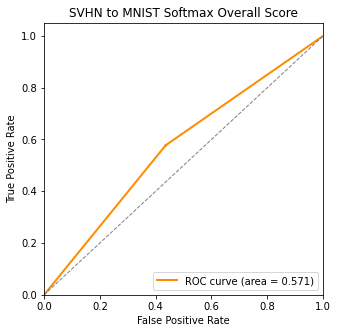

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('SVHN to MNIST Softmax Overall Score')

fig.savefig(os.path.join(runpath, 'softmax_svhn_mnist_eval_test.png'), dpi=300)
fig.show()

To USPS:

In [ ]:
X_origin = tf.gather(usps_X_test, usps_0_4)
X_novel = tf.gather(usps_X_test, usps_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_softmax, X_tgt)

Novelty Detector - Computing Outputs


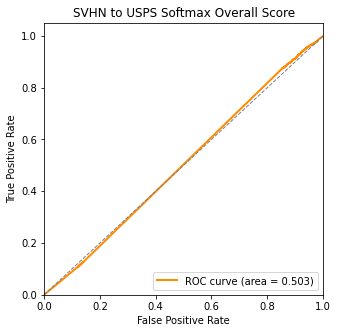

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('SVHN to USPS Softmax Overall Score')

fig.savefig(os.path.join(runpath, 'softmax_svhn_usps_eval_test.png'), dpi=300)
fig.show()

### USPS to MNIST

#### Training

In [ ]:
mod_softmax = SoftMaxModel()

In [ ]:
opt = []
for i in range(2):
    opt.append(keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
X_src_3 = tf.gather(usps_X_train, usps_0_4)
y_src_3 = tf.gather(usps_y_train, usps_0_4)

In [ ]:
history_3 = train_softmax_model(mod_softmax, X_src_3, y_src_3,
                                optimizers = opt, n_epochs = 10,
                                batch_size=64, name='usps_mnist')

Epoch 1/10
4240/4240 - loss_ce: 0.8048
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_usps_mnist_epoch_1_2020_12_05-21_40_13/assets
Epoch 2/10
4240/4240 - loss_ce: 0.1367
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_usps_mnist_epoch_2_2020_12_05-21_40_16/assets
Epoch 3/10
4240/4240 - loss_ce: 0.0992
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_usps_mnist_epoch_3_2020_12_05-21_40_18/assets
Epoch 4/10
4240/4240 - loss_ce: 0.0880
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_usps_mnist_epoch_4_2020_12_05-21_40_20/assets
Epoch 5/10
4240/4240 - loss_ce: 0.0647
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_05-21_29/SOFTMAX_usps_m

In [ ]:
history_3.shape

(660, 1)

Visualize the Training History

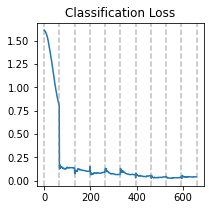

In [ ]:
epoch_index = np.linspace(0,len(history_3),11)
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(range(len(history_3)), history_3[:,0])
ax.set_title('Classification Loss')
for j in range(len(epoch_index)):
    ax.axvline(epoch_index[j], c='gray', ls='--', alpha=0.5)
    
fig.savefig(os.path.join(runpath, 'softmax_usps_mnist_loss.png'), dpi=300)
fig.show()

#### Diagnostic Tests

**Load model trained before**

In [ ]:
# mod_softmax = tf.keras.models.load_model('SOFTMAX_mnist_usps_epoch_5_2020_12_04-21_51_28')

Sample a random batch of samples and see the softmax probability scores.

In [ ]:
index = np.random.randint(0, min(len(mnist_0_4), len(mnist_5_9)), 10)
X_origin_rand = tf.gather(mnist_X_train, mnist_0_4[index])
y_origin_rand = mnist_y_train[mnist_0_4[index]]
X_novel_rand = tf.gather(mnist_X_train, mnist_5_9[index])
y_novel_rand = mnist_y_train[mnist_5_9[index]]

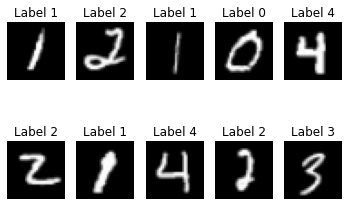

In [ ]:
plot_color_digits(X_origin_rand, y_origin_rand, (2,5))

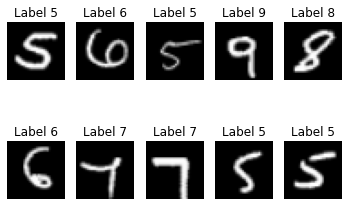

In [ ]:
plot_color_digits(X_novel_rand, y_novel_rand, (2,5))

In [ ]:
y_origin_pred = mod_softmax(X_origin_rand)
y_novel_pred = mod_softmax(X_novel_rand)

In [ ]:
tf.nn.softmax(y_origin_pred), tf.math.argmax(y_origin_pred,axis=1).numpy(), y_origin_rand

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[5.0698062e-03, 3.9718071e-01, 1.3375048e-02, 5.0698062e-03,
         5.7930464e-01],
        [5.2569661e-04, 2.9236128e-04, 9.4988453e-01, 3.0857281e-04,
         4.8988935e-02],
        [5.1187880e-02, 5.0420082e-01, 5.1187880e-02, 5.1187880e-02,
         3.4223557e-01],
        [9.8991698e-01, 2.4187034e-04, 2.0641431e-03, 2.5759463e-03,
         5.2010245e-03],
        [1.7990043e-05, 1.3965650e-05, 2.9516261e-05, 3.8148937e-05,
         9.9990034e-01],
        [9.1981916e-03, 2.4197249e-02, 9.7703263e-02, 2.5362436e-02,
         8.4353888e-01],
        [2.7470884e-03, 3.7955239e-01, 7.4748239e-03, 8.4184008e-03,
         6.0180736e-01],
        [7.1650039e-04, 2.7883996e-04, 8.6196307e-03, 3.2309254e-04,
         9.9006200e-01],
        [6.8796352e-03, 5.5560631e-01, 1.6502327e-01, 6.8796352e-03,
         2.6561111e-01],
        [1.5550053e-02, 2.9946184e-01, 1.5550053e-02, 1.9665284e-01,
         4.7278515e-01]], dtype=flo

In [ ]:
tf.nn.softmax(y_novel_pred), tf.math.argmax(y_novel_pred,axis=1).numpy(), y_novel_rand

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[1.91210032e-01, 4.32329765e-03, 3.48738804e-02, 1.77651361e-01,
         5.91941416e-01],
        [8.84763151e-03, 3.30984214e-04, 1.47384102e-03, 3.30984214e-04,
         9.89016533e-01],
        [1.32867485e-01, 3.50166373e-02, 5.24454229e-02, 4.79256548e-02,
         7.31744766e-01],
        [1.29313720e-03, 1.99693546e-04, 1.99693546e-04, 6.68071385e-04,
         9.97639418e-01],
        [2.40653306e-02, 6.72758073e-02, 3.21853280e-01, 1.71680804e-02,
         5.69637477e-01],
        [2.66998727e-03, 5.75071294e-03, 1.18530095e-01, 2.66998727e-03,
         8.70379210e-01],
        [6.42572704e-04, 6.42572704e-04, 6.42572704e-04, 5.42339124e-03,
         9.92648900e-01],
        [2.44712015e-03, 2.07111501e-04, 2.07111501e-04, 7.56784854e-03,
         9.89570856e-01],
        [1.23762432e-02, 2.52686769e-01, 1.23762432e-02, 9.99836400e-02,
         6.22577131e-01],
        [1.53109655e-02, 1.32269040e-02, 1.18214183e-01, 2.

In [ ]:
tf.math.reduce_max(y_origin_pred,axis=1).numpy(), tf.math.reduce_max(y_novel_pred,axis=1).numpy()

(array([ 4.738526 ,  8.086105 ,  2.2874718,  8.316975 , 11.17881  ,
         5.233408 ,  5.3893957,  8.174885 ,  4.3914943,  3.414577 ],
       dtype=float32),
 array([4.9193892, 8.002396 , 3.0396085, 8.516363 , 4.468586 , 5.786855 ,
        7.3426523, 8.471769 , 3.9180887, 4.903224 ], dtype=float32))

#### Novelty Detector on Target Training Set

In [ ]:
X_origin = tf.gather(mnist_X_train, mnist_0_4)
X_novel = tf.gather(mnist_X_train, mnist_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_softmax, X_tgt)

Novelty Detector - Computing Outputs


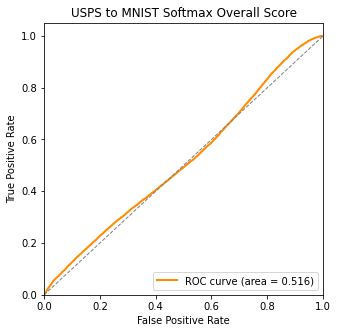

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('USPS to MNIST Softmax Overall Score')

fig.savefig(os.path.join(runpath, 'softmax_usps_mnist_eval_train.png'), dpi=300)
fig.show()

#### Novelty Detector on Target Test Set

In [ ]:
X_origin = tf.gather(mnist_X_test, mnist_0_4t)
X_novel = tf.gather(mnist_X_test, mnist_5_9t)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_softmax, X_tgt)

Novelty Detector - Computing Outputs


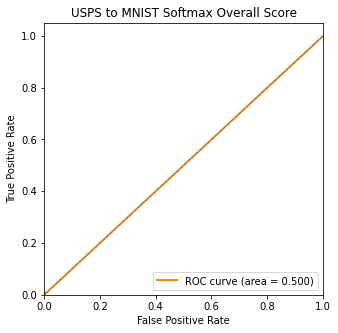

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('USPS to MNIST Softmax Overall Score')

fig.savefig(os.path.join(runpath, 'softmax_usps_mnist_eval_test.png'), dpi=300)
fig.show()